In [1]:
import pandas as pd
import re
from sqlalchemy import create_engine
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
db_path = os.path.join(project_root, "data", "weather.db")
connection_str = f"sqlite:///{db_path}"
engine = create_engine(connection_str, connect_args={"check_same_thread": False})

In [2]:
def single_station_load(engine, station_id):
    query = "SELECT * FROM clean_station_data WHERE station_id=:sid"
    params = {'sid': station_id}
    df_out = pd.read_sql(query, engine, params=params)
    return df_out

df_haifa = single_station_load(engine, 43)
df_tel_aviv = single_station_load(engine, 178)
df_afula = single_station_load(engine, 16)
df_afula.head()

,timestamp,rain,wsmax,wdmax,ws,stdwd,td,rh,tdmax,tdmin,ws1mm,ws10mm,u_vec,v_vec,rain_intensity_max,station_id,latitude,longitude
0,2019-12-31 22:00:00.000000,0.0,1.4,322.0,0.666667,13.300000,8.833333,91.333333,9.5,8.1,1.3,1.2,0.312851,-0.347125,0.0,16,32.596,35.2769
1,2019-12-31 23:00:00.000000,0.0,1.5,276.0,0.866667,11.416667,7.783333,97.166667,8.2,7.1,1.3,1.2,0.852835,0.133639,0.0,16,32.596,35.2769
2,2020-01-01 00:00:00.000000,0.0,1.8,290.0,1.033333,13.050000,6.883333,99.833333,7.3,6.2,1.7,1.3,0.992793,0.091221,0.0,16,32.596,35.2769
3,2020-01-01 01:00:00.000000,0.0,1.8,352.0,0.616667,24.750000,6.000000,100.000000,6.5,5.5,1.6,1.2,0.318678,0.120158,0.0,16,32.596,35.2769
4,2020-01-01 02:00:00.000000,0.0,1.8,229.0,0.916667,14.600000,5.783333,100.000000,6.2,5.5,1.6,1.4,0.383916,0.733935,0.0,16,32.596,35.2769


In [3]:
print(df_afula.shape)
print(df_afula.columns.tolist())

(43848, 18)
['timestamp', 'rain', 'wsmax', 'wdmax', 'ws', 'stdwd', 'td', 'rh', 'tdmax', 'tdmin', 'ws1mm', 'ws10mm', 'u_vec', 'v_vec', 'rain_intensity_max', 'station_id', 'latitude', 'longitude']


In [4]:
def sort_by_ts(df: pd.DataFrame):
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df.set_index('timestamp', inplace=True)
    df.sort_index(axis=0, ascending=True, inplace=True)

sort_by_ts(df_afula)
sort_by_ts(df_tel_aviv)
sort_by_ts(df_haifa)

## Feature engineering functions (timelags/upstream)

In [5]:
def create_local_lags(df: pd.DataFrame, lag_hours=[1, 2, 3, 6, 12, 24]):
    """
    Creates autoregressive lag features for a single station's dataframe.
    Assumes df is already filtered for ONE station and sorted by time.
    """
    df_out = df.copy()
    target_cols = ['rain', 'u_vec', 'v_vec', 'td', 'rh', 'rain_intensity_max']

    for col in target_cols:
        if col in df_out.columns:
            for h in lag_hours:
                feat_name = f"{col}_t-{h}h"
                df_out[feat_name] = df_out[col].shift(h)


    df_out['target_rain_t+1'] = df_out['rain'].shift(-1)
    return df_out

In [6]:
def add_upstream_features(df_target: pd.DataFrame, df_upstream: pd.DataFrame, upstream_name, lag_hours=[1, 2, 3], join_type='left'):
    """
    Joins upstream station data onto the target station.
    """
    force_cols = ['rain', 'u_vec', 'v_vec', 'rh']
    renamed_cols = {c: f"{c}_{upstream_name}" for c in force_cols}
    df_force = df_upstream[force_cols].rename(columns=renamed_cols).reindex(df_target.index)
    
    # Add physics features
    df_force[f"u_convergence_{upstream_name}"] = df_force[f"u_vec_{upstream_name}"] - df_target["u_vec"]
    df_force[f"v_convergence_{upstream_name}"] = df_force[f"v_vec_{upstream_name}"] - df_target["v_vec"]
    df_force[f"moisture_flux_{upstream_name}"] = df_force[f"u_vec_{upstream_name}"] * df_force[f"rh_{upstream_name}"]

    cols_to_lag = list(df_force.columns)
    for col in cols_to_lag:
        for h in lag_hours:
            df_force[f"{col}_t-{h}h"] = df_force[col].shift(h)

    # Constraint flitering logic
    rain_keywords = ['rain', 'convergence', 'moisture_flux', 'rh']
    full_constraints = {}
    for col in df_force.columns:
        if any(keyword in col for keyword in rain_keywords):
            full_constraints[col] = 1

    df_merged = df_target.join(df_force, how=join_type)

    return df_merged

In [7]:
def get_constraints(df: pd.DataFrame, target_pattern: str = r't\+\d+'):
    rain_keywords = ['rain', 'convergence', 'moisture_flux', 'rh']
    negative_keywords = ['td', 'tdmax']
    full_constraints = {}
    for col in df.columns:
        if re.search(target_pattern, col):
            continue

        if any(keyword in col for keyword in negative_keywords):
            full_constraints[col] = -1

        if any(keyword in col for keyword in rain_keywords):
            full_constraints[col] = 1

    return full_constraints

## Data splitting with time-series preservation

In [8]:
def temporal_split(df: pd.DataFrame, target_col, val_start_date, test_start_date):
    """
    Splits time-series data into training/validation/testing sets
    
    :param df: Pandas DataFrame
    :param val_start_date: String representation 'yyyy-mm-dd'
    :param test_start_date: String representation 'yyyy-mm-dd'

    Returns:
        SplitDataFrames: X_train, X_val, X_test, y_train, y_val, y_test
    """
    feature_cols = [c for c in df.columns if c != target_col]
    X = df[feature_cols]
    y = df[target_col]

    X_train = X[X.index < val_start_date]
    y_train = y[y.index < val_start_date]

    mask_val = (X.index >= val_start_date) & (X.index < test_start_date)
    X_val = X[mask_val]
    y_val = y[mask_val]

    X_test = X[X.index >= test_start_date]
    y_test = y[y.index >= test_start_date]

    return X_train, X_val, X_test, y_train, y_val, y_test


Simple dataframe processing to remove structural nulls

In [9]:
def prepare_dataset(df, target_col='target_rain_t+1', max_lag=6):
    print(df.shape)
    df_lagged = create_local_lags(df)
    df_trimmed = df_lagged.iloc[max_lag:]
    df_final = df_trimmed.dropna(subset=[target_col])
    
    return df_final

**Here we construct the master time index to join other tables on it.**

**This allows us to preserve the temporal structure of the dataset.**

In [10]:
def create_production_backbone(raw_start_str, raw_end_str, max_lag_hours, freq='h'):
    """
    Creates a Master Time Index that starts EXACTLY after the warm-up period.
    This ensures every row in the resulting dataframe is valid for inference.
    """
    t0 = pd.Timestamp(raw_start_str)
    tend = pd.Timestamp(raw_end_str)
    
    effective_start = t0 + pd.Timedelta(hours=max_lag_hours)
    
    print(f"Raw Start:      {t0}")
    print(f"Warmup Period:  {max_lag_hours} hours")
    print(f"Index Starts:   {effective_start} (First Predictable Row)")
    
    master_index = pd.date_range(start=effective_start, end=tend, freq=freq)
    
    df_master = pd.DataFrame(index=master_index)
    df_master.index.name = 'timestamp'
    
    return df_master


df_backbone = create_production_backbone(
    raw_start_str="2020-01-01 00:00:00",
    raw_end_str="2025-01-01 00:00:00",
    max_lag_hours=24
)

df_backbone.head()

Raw Start:      2020-01-01 00:00:00
Warmup Period:  24 hours
Index Starts:   2020-01-02 00:00:00 (First Predictable Row)


""
timestamp
2020-01-02 00:00:00
2020-01-02 01:00:00
2020-01-02 02:00:00
2020-01-02 03:00:00
2020-01-02 04:00:00


**Constructing DataFrames**

In [11]:
df_afula_lags = prepare_dataset(df_afula, target_col='target_rain_t+1', max_lag=24)
display(df_afula_lags)
df_afula_lags = (df_backbone.join(df_afula_lags, how='left')).dropna(subset=['target_rain_t+1'])
display(df_afula_lags)

df_afula_lags_upstream_TA = add_upstream_features(
    df_afula_lags,
    df_tel_aviv,
    upstream_name="tel_aviv",
    join_type='left'
)
constraints_TA = get_constraints(df_afula_lags_upstream_TA)

df_afula_lags_upstream_TA_HA = add_upstream_features(
    df_afula_lags_upstream_TA,
    df_haifa,
    upstream_name="haifa",
    join_type='left'
)
constraints_TA_HA = get_constraints(df_afula_lags_upstream_TA_HA)

(43848, 17)


,rain,wsmax,wdmax,ws,stdwd,td,rh,tdmax,tdmin,ws1mm,...,rh_t-6h,rh_t-12h,rh_t-24h,rain_intensity_max_t-1h,rain_intensity_max_t-2h,rain_intensity_max_t-3h,rain_intensity_max_t-6h,rain_intensity_max_t-12h,rain_intensity_max_t-24h,target_rain_t+1
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01 22:00:00,0.0,1.6,188.0,0.533333,9.166667,10.400000,100.0,10.5,10.3,1.4,...,98.166667,78.000000,91.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 23:00:00,0.0,1.7,338.0,0.466667,10.333333,10.516667,100.0,10.6,10.5,1.4,...,99.000000,90.666667,97.166667,0.0,0.0,0.0,0.0,0.4,0.0,0.0
2020-01-02 00:00:00,0.0,1.6,287.0,0.683333,22.033333,10.433333,100.0,10.6,10.1,1.4,...,99.666667,93.166667,99.833333,0.0,0.0,0.0,0.0,0.2,0.0,0.0
2020-01-02 01:00:00,0.0,2.5,307.0,1.050000,13.200000,9.650000,100.0,10.2,9.3,2.4,...,99.833333,91.666667,100.000000,0.0,0.0,0.0,0.0,0.2,0.0,0.0
2020-01-02 02:00:00,0.0,1.6,311.0,0.650000,25.683333,8.833333,100.0,9.3,7.6,1.4,...,99.666667,95.500000,100.000000,0.0,0.0,0.0,0.0,0.6,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 16:00:00,0.0,1.4,354.0,0.433333,23.383333,10.550000,93.0,10.8,10.2,1.2,...,80.833333,88.500000,91.666667,0.0,0.0,0.0,10.7,0.2,0.1,0.0
2024-12-31 17:00:00,0.0,2.6,262.0,1.266667,14.066667,9.616667,94.0,10.2,9.1,2.4,...,87.833333,91.333333,91.500000,0.0,0.0,0.0,0.9,0.6,0.6,0.0
2024-12-31 18:00:00,0.0,2.5,252.0,0.916667,16.350000,9.833333,95.0,10.0,9.4,2.1,...,89.666667,92.666667,92.166667,0.0,0.0,0.0,0.0,0.1,0.9,0.0


,rain,wsmax,wdmax,ws,stdwd,td,rh,tdmax,tdmin,ws1mm,...,rh_t-6h,rh_t-12h,rh_t-24h,rain_intensity_max_t-1h,rain_intensity_max_t-2h,rain_intensity_max_t-3h,rain_intensity_max_t-6h,rain_intensity_max_t-12h,rain_intensity_max_t-24h,target_rain_t+1
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-02 00:00:00,0.0,1.6,287.0,0.683333,22.033333,10.433333,100.0,10.6,10.1,1.4,...,99.666667,93.166667,99.833333,0.0,0.0,0.0,0.0,0.2,0.0,0.0
2020-01-02 01:00:00,0.0,2.5,307.0,1.050000,13.200000,9.650000,100.0,10.2,9.3,2.4,...,99.833333,91.666667,100.000000,0.0,0.0,0.0,0.0,0.2,0.0,0.0
2020-01-02 02:00:00,0.0,1.6,311.0,0.650000,25.683333,8.833333,100.0,9.3,7.6,1.4,...,99.666667,95.500000,100.000000,0.0,0.0,0.0,0.0,0.6,0.0,0.0
2020-01-02 03:00:00,0.0,2.5,330.0,0.783333,13.816667,7.550000,100.0,7.8,7.3,2.3,...,100.000000,97.500000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-02 04:00:00,0.0,1.0,145.0,0.300000,20.850000,8.033333,100.0,8.3,7.6,0.8,...,100.000000,98.166667,100.000000,0.0,0.0,0.0,0.0,0.0,0.1,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 16:00:00,0.0,1.4,354.0,0.433333,23.383333,10.550000,93.0,10.8,10.2,1.2,...,80.833333,88.500000,91.666667,0.0,0.0,0.0,10.7,0.2,0.1,0.0
2024-12-31 17:00:00,0.0,2.6,262.0,1.266667,14.066667,9.616667,94.0,10.2,9.1,2.4,...,87.833333,91.333333,91.500000,0.0,0.0,0.0,0.9,0.6,0.6,0.0
2024-12-31 18:00:00,0.0,2.5,252.0,0.916667,16.350000,9.833333,95.0,10.0,9.4,2.1,...,89.666667,92.666667,92.166667,0.0,0.0,0.0,0.0,0.1,0.9,0.0


Filtering feature names that have direct impact on chance of precipitation

**Checking timestamp continuity**

In [12]:
def check_timestamp_holes(df, freq='h'):
    """
    Checks if a DataFrame index has any missing timestamps (holes).
    """
    if df.empty:
        print("DataFrame is empty!")
        return

    if not isinstance(df.index, pd.DatetimeIndex):
        try:
            df.index = pd.to_datetime(df.index)
        except:
            print("Error: Index is not datetime and cannot be converted.")
            return

    start_time = df.index.min()
    end_time = df.index.max()
    perfect_index = pd.date_range(start=start_time, end=end_time, freq=freq)

    missing_timestamps = perfect_index.difference(df.index)

    if len(missing_timestamps) == 0:
        print(f"SUCCESS: No holes found. Timeline is continuous from {start_time} to {end_time}.")
        print(f"Total rows: {len(df)}")
    else:
        print(f"WARNING: Found {len(missing_timestamps)} missing timestamps!")
        print("First 5 missing holes:")
        print(missing_timestamps[:5])

check_timestamp_holes(df_afula, freq='h')
check_timestamp_holes(df_afula_lags_upstream_TA_HA, freq='h')

SUCCESS: No holes found. Timeline is continuous from 2019-12-31 22:00:00 to 2024-12-31 21:00:00.
Total rows: 43848
SUCCESS: No holes found. Timeline is continuous from 2020-01-02 00:00:00 to 2024-12-31 20:00:00.
Total rows: 43821


**Inspecting rainy months**

/tmp/ipykernel_62786/1339524739.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_rain_counts.index, y=monthly_rain_counts.values, palette="Blues_d")


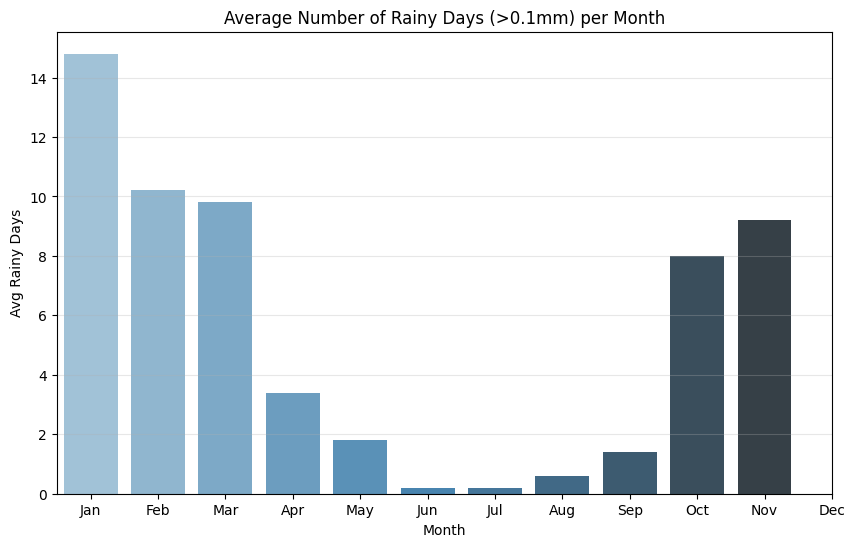

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Resample to Daily Totals (since your data is hourly)
# We only care if the WHOLE day had > 0.1mm
daily_rain = df_afula_lags_upstream_TA_HA['rain'].resample('D').sum()

rainy_days = daily_rain[daily_rain > 0.1]

# We normalize by the number of years to get "Average Rainy Days per Month"
unique_years = df_afula_lags_upstream_TA_HA.index.year.nunique()
monthly_rain_counts = rainy_days.groupby(rainy_days.index.month).count() / unique_years

plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_rain_counts.index, y=monthly_rain_counts.values, palette="Blues_d")

plt.title(f"Average Number of Rainy Days (>0.1mm) per Month")
plt.xlabel("Month")
plt.ylabel("Avg Rainy Days")
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y', alpha=0.3)
plt.show()

**Checking feature correlations**

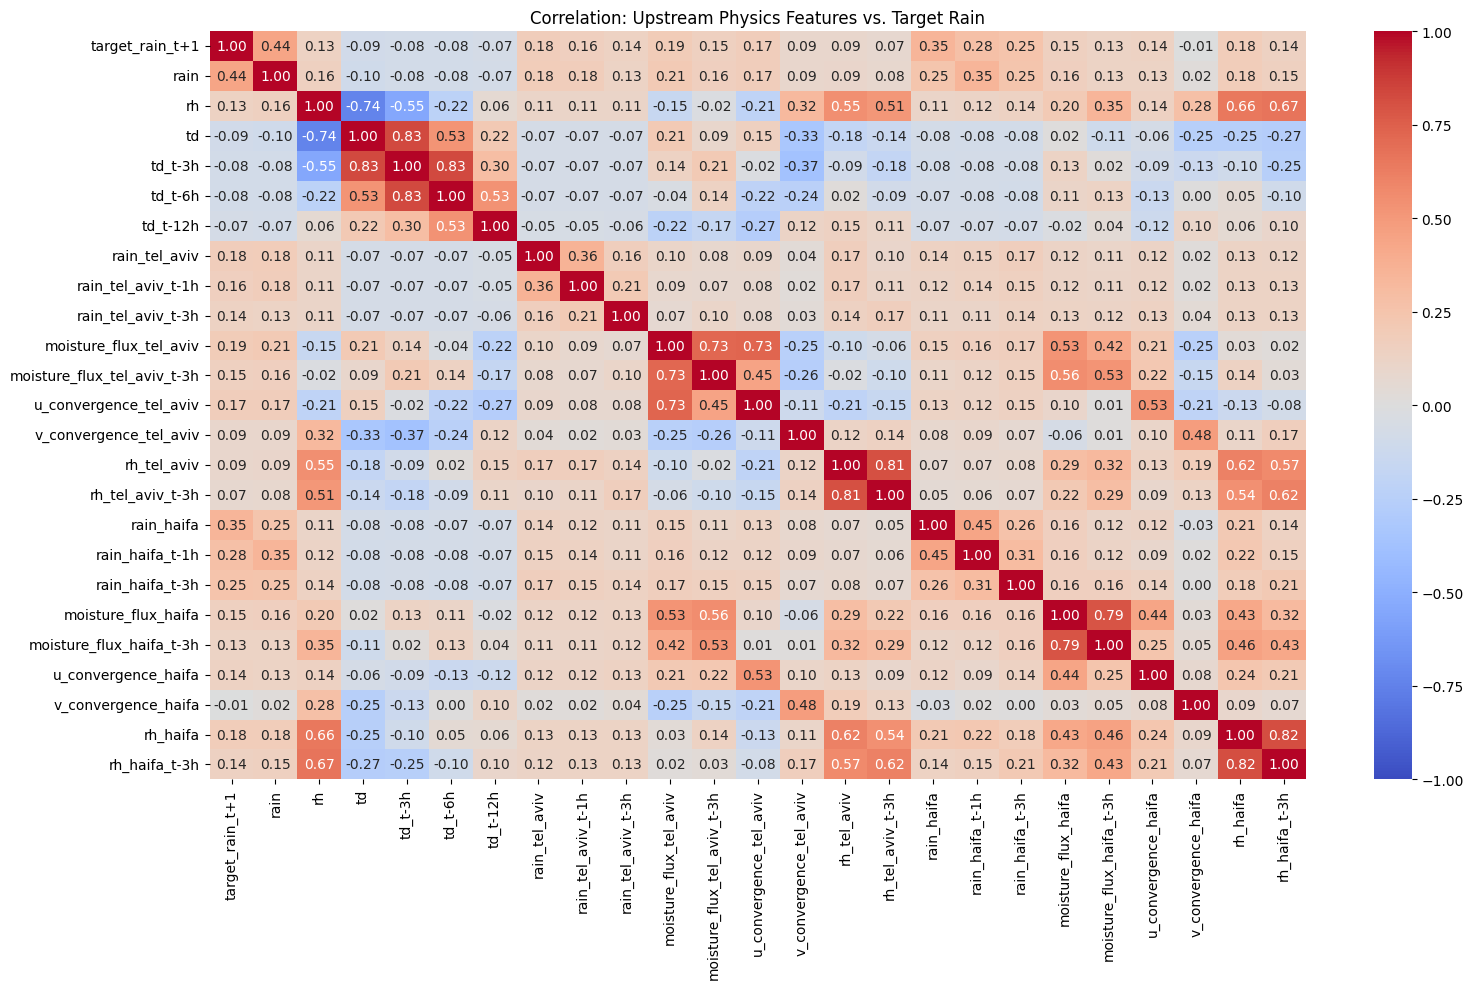

In [14]:
# Filtering winter only season to observe true correlations in winter season
winter_months = [10, 11, 12, 1, 2, 3]
df_winter = df_afula_lags_upstream_TA_HA[df_afula_lags_upstream_TA_HA.index.month.isin(winter_months)].copy()

corr_cols = [
    'target_rain_t+1',
    'rain',
    'rh',
    'td',
    'td_t-3h',
    'td_t-6h',
    'td_t-12h',
    'rain_tel_aviv',
    'rain_tel_aviv_t-1h',
    'rain_tel_aviv_t-3h',
    'moisture_flux_tel_aviv',
    'moisture_flux_tel_aviv_t-3h',
    'u_convergence_tel_aviv',
    'v_convergence_tel_aviv',
    'rh_tel_aviv',
    'rh_tel_aviv_t-3h',
    'rain_haifa',
    'rain_haifa_t-1h',
    'rain_haifa_t-3h',
    'moisture_flux_haifa',
    'moisture_flux_haifa_t-3h',
    'u_convergence_haifa',
    'v_convergence_haifa',
    'rh_haifa',
    'rh_haifa_t-3h',
]

plot_cols = [c for c in corr_cols if c in df_winter.columns]

plt.figure(figsize=(16, 10))

# Create correlation matrix
corr_matrix = df_winter[plot_cols].corr()

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation: Upstream Physics Features vs. Target Rain")
plt.tight_layout()
plt.show()

## Explaining Winter Season Correlations

1. **Moisture Flux Haifa vs. Tel Aviv (0.53): The "Regional Faucet"**

    The strong correlation between these coastal cities confirms they are fed by the same synoptic system ("The Faucet"). This proves that when the "moisture switch" is turned on for the region, it activates the entire coastline simultaneously, providing a robust, redundant signal for the model.

2. **u_convergence vs. Moisture Flux (0.73): The "Traffic Jam" Effect**

    This correlation validates the "Fuel & Spark" physics. The convergence calculates the "Traffic Jam" of air: fast coastal winds slam into the slower inland air, forcing the mass upward ("The Spark"). When this happens simultaneously with high moisture flux ("The Fuel"), the model successfully identifies the exact moment of storm generation.

3. **Tel Aviv RH (0.55) > Tel Aviv Lagged RH (0.51): The "Synoptic Blanket"**

    The immediate correlation is stronger than the lagged one, indicating that Tel Aviv represents the regional background state rather than a direct transport mechanism. When Tel Aviv is humid, the entire country is likely under a humid system, making it a powerful "Context" feature.

4. **Haifa RH (0.67 at both t and t−3h): The "Jezreel Valley Pipeline"**

    The exceptionally high and stable correlation across time lags confirms a continuous, direct air-mass connection between Haifa Bay and Afula. This proves the valley acts as an open wind tunnel, making Haifa the primary "Source" feature for inland humidity.

5. **Haifa Rain vs. Afula Rain t+1 (0.35): The "Physical Storm Track"**

    This correlation captures the kinematic reality of storm cells. A 0.35 correlation with a sparse target (rain) is statistically significant and confirms the 1-hour travel time for active storm cells moving from the coast inland.

6. **td vs. rh at Afula (-0.74): "The Clausius-Clapeyron Law"**

    This is the strongest signal because it is a fundamental law of physics, not just weather.

    The Physics: Warm air can hold more water vapor than cold air. If the absolute amount of water remains constant, raising the Temperature (td) causes Relative Humidity (rh) to plummet.
    
    The Verdict: A correlation of -0.74 is exactly what we expect to see.

## XGBoost no feature engineering

In [15]:
val_start_date = '2023-01-01'
test_start_date = '2024-01-01'

X_train, X_val, X_test, y_train, y_val, y_test = temporal_split(
    df_afula_lags,
    'target_rain_t+1',
    val_start_date,
    test_start_date
)

X_train

,rain,wsmax,wdmax,ws,stdwd,td,rh,tdmax,tdmin,ws1mm,...,rh_t-3h,rh_t-6h,rh_t-12h,rh_t-24h,rain_intensity_max_t-1h,rain_intensity_max_t-2h,rain_intensity_max_t-3h,rain_intensity_max_t-6h,rain_intensity_max_t-12h,rain_intensity_max_t-24h
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-02 00:00:00,0.0,1.6,287.0,0.683333,22.033333,10.433333,100.000000,10.6,10.1,1.4,...,100.000000,99.666667,93.166667,99.833333,0.0,0.0,0.0,0.0,0.2,0.0
2020-01-02 01:00:00,0.0,2.5,307.0,1.050000,13.200000,9.650000,100.000000,10.2,9.3,2.4,...,100.000000,99.833333,91.666667,100.000000,0.0,0.0,0.0,0.0,0.2,0.0
2020-01-02 02:00:00,0.0,1.6,311.0,0.650000,25.683333,8.833333,100.000000,9.3,7.6,1.4,...,100.000000,99.666667,95.500000,100.000000,0.0,0.0,0.0,0.0,0.6,0.0
2020-01-02 03:00:00,0.0,2.5,330.0,0.783333,13.816667,7.550000,100.000000,7.8,7.3,2.3,...,100.000000,100.000000,97.500000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-02 04:00:00,0.0,1.0,145.0,0.300000,20.850000,8.033333,100.000000,8.3,7.6,0.8,...,100.000000,100.000000,98.166667,100.000000,0.0,0.0,0.0,0.0,0.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,0.0,6.7,120.0,3.083333,14.883333,14.516667,60.333333,14.9,14.1,5.4,...,59.666667,49.500000,55.666667,50.000000,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-31 20:00:00,0.0,6.5,127.0,3.833333,8.533333,13.850000,61.833333,14.6,13.3,5.6,...,61.000000,51.833333,51.833333,51.666667,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-31 21:00:00,0.0,6.0,146.0,3.550000,9.266667,12.983333,64.333333,13.4,12.6,4.6,...,61.333333,55.666667,51.500000,51.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error

val_start_date = '2023-01-01'
test_start_date = '2024-01-01'

X_train, X_val, X_test, y_train, y_val, y_test = temporal_split(
    df_afula_lags,
    'target_rain_t+1',
    val_start_date,
    test_start_date
)

ignore_cols = ['timestamp', 'station_id', 'longitude', 'latitude']
X_train = X_train.drop(columns=ignore_cols, errors='ignore')
X_val = X_val.drop(columns=ignore_cols, errors='ignore')
X_test = X_test.drop(columns=ignore_cols, errors='ignore')

basic_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    objective='reg:tweedie',
    tweedie_variance_power=1.5,
    n_jobs=-1,
    missing=np.nan,
    early_stopping_rounds=50
)

basic_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

preds_test = basic_model.predict(X_test)

## XGBoost with upstream features and feature engineering

**XGBoost with telaviv only**

In [17]:
X_train, X_val, X_test, y_train, y_val, y_test = temporal_split(
    df_afula_lags_upstream_TA,
    'target_rain_t+1',
    val_start_date,
    test_start_date
)

X_train = X_train.drop(columns=ignore_cols, errors='ignore')
X_val = X_val.drop(columns=ignore_cols, errors='ignore')
X_test = X_test.drop(columns=ignore_cols, errors='ignore')

# Assign higher weights to rainy days so that the model gets punished
# for getting incorrect forecasts even harder
sample_weights = np.ones(len(y_train))
sample_weights[y_train > 0] = 10.0

boosted_model1 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    objective='reg:tweedie',
    tweedie_variance_power=1.5,
    n_jobs=-1,
    early_stopping_rounds=50,
    missing=np.nan,
    monotone_constraints=constraints_TA
)

boosted_model1.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    sample_weight=sample_weights,
    verbose=False
)

preds_test_boosted1 = boosted_model1.predict(X_test)

**XGBoost with haifa and telaviv**

In [18]:
X_train, X_val, X_test, y_train, y_val, y_test = temporal_split(
    df_afula_lags_upstream_TA_HA,
    'target_rain_t+1',
    val_start_date,
    test_start_date
)

X_train = X_train.drop(columns=ignore_cols, errors='ignore')
X_val = X_val.drop(columns=ignore_cols, errors='ignore')
X_test = X_test.drop(columns=ignore_cols, errors='ignore')

boosted_model2 = xgb.XGBRegressor(
    n_estimators=5000,
    learning_rate=0.05,
    max_depth=6,
    objective='reg:tweedie',
    tweedie_variance_power=1.5,
    n_jobs=-1,
    early_stopping_rounds=50,
    missing=np.nan,
    monotone_constraints=constraints_TA_HA
)

boosted_model2.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    sample_weight=sample_weights,
    verbose=False
)

preds_test_boosted2 = boosted_model2.predict(X_test)

**BASELINE 0 Complexity Model**

In [19]:
preds_presistence = X_test['rain']

Conditional RMSE

In [20]:
def storm_rmse(y_pred, y_test, model_name):
    mask_rainy = y_test > 0.1

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(model_name + ':')
    print(f"GLOBAL t+1 RMSE: {rmse:.4f} mm")

    if mask_rainy.sum() > 0:
        y_rainy = y_test[mask_rainy]
        pred_rainy = y_pred[mask_rainy]
        rmse_rainy = np.sqrt(mean_squared_error(y_rainy, pred_rainy))
        print(f"Storm-Only t+1 RMSE: {rmse_rainy:.4f} mm")

        # Calculate Bias: Are we systematically under or over forecasting?
        # Negative = Under-forecasting (Dangerous)
        bias = np.mean(y_pred[mask_rainy] - y_test[mask_rainy])
        
        # Calculate Scatter Index: Relative error
        rmse_rainy = np.sqrt(mean_squared_error(y_test[mask_rainy], y_pred[mask_rainy]))
        scatter_index = (rmse_rainy / np.mean(y_test[mask_rainy])) * 100
        
        print(f"Storm Intensity Bias: {bias:.2f} mm")
        print(f"Storm Scatter Index: {scatter_index:.1f}%")
        print()
    else:
        print("No rain events in the test set!")


# On our baseline presistence model
storm_rmse(preds_presistence, y_test, 'Baseline Persistence')

# On our baseline XGBoost
storm_rmse(preds_test, y_test, 'Baseline XGBoost')

# On our XGBoost with upstream from Telaviv and Haifa
storm_rmse(preds_test_boosted2, y_test, 'XGBoost upstream Telaviv Haifa')


Baseline Persistence:
GLOBAL t+1 RMSE: 0.5996 mm
Storm-Only t+1 RMSE: 2.7222 mm
Storm Intensity Bias: -0.46 mm
Storm Scatter Index: 161.2%

Baseline XGBoost:
GLOBAL t+1 RMSE: 0.4977 mm
Storm-Only t+1 RMSE: 2.3977 mm
Storm Intensity Bias: -1.28 mm
Storm Scatter Index: 142.0%

XGBoost upstream Telaviv Haifa:
GLOBAL t+1 RMSE: 0.4724 mm
Storm-Only t+1 RMSE: 2.1084 mm
Storm Intensity Bias: -0.64 mm
Storm Scatter Index: 124.9%



As we can see, the addition of the upstream feature feeders like haifa and telaviv improved the model's overall performance.

It went from a model relying solely on its own history to forecast to a model that has "eyes" that can see incoming storms/winds/precipitation from telaviv and haifa coastal stations.

## Plotting feature importances and impacts

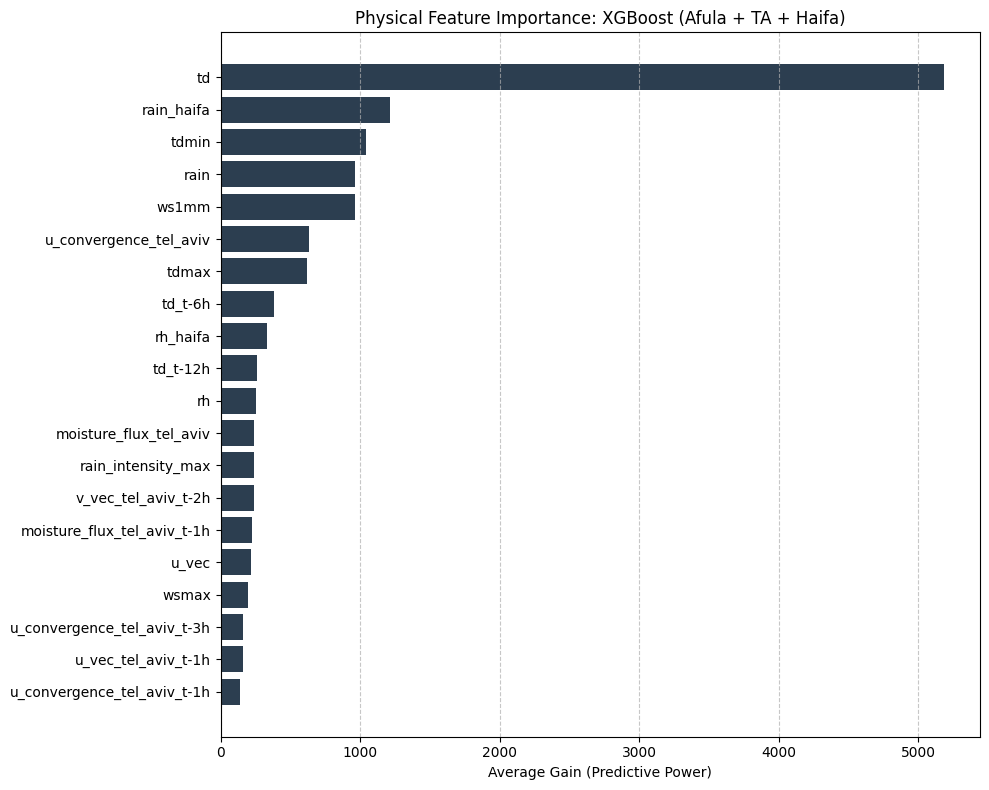

In [21]:
import matplotlib.pyplot as plt

def plot_physical_importance(model, model_name):
    # 'gain' = Average improvement in accuracy brought by a feature
    importance = model.get_booster().get_score(importance_type='gain')
    
    # Sort and take top 20 for readability
    sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:20]
    
    features, scores = zip(*sorted_importance)
    
    plt.figure(figsize=(10, 8))
    plt.barh(features, scores, color='#2c3e50')
    plt.xlabel('Average Gain (Predictive Power)')
    plt.title(f'Physical Feature Importance: {model_name}')
    plt.gca().invert_yaxis()  # Highest importance at top
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run on your final spatial model
plot_physical_importance(boosted_model2, "XGBoost (Afula + TA + Haifa)")

Binary representation of model's accuracy for precipitation

In [22]:
from sklearn.metrics import classification_report

y_test_bin = (y_test >= 0.1).astype(int)
preds_bin = (preds_test_boosted2 >= 0.5).astype(int)


print("Classification Report for XGBoost pre-tuning")
print(classification_report(y_test_bin, preds_bin, target_names=['Dry', 'Rain']))

Classification Report for XGBoost pre-tuning
              precision    recall  f1-score   support

         Dry       0.98      0.97      0.98      8321
        Rain       0.61      0.72      0.66       460

    accuracy                           0.96      8781
   macro avg       0.80      0.85      0.82      8781
weighted avg       0.96      0.96      0.96      8781



These metrics indicate a safety-biased configuration suitable for operational hazard warning. While the model accepts a ~63% False Alarm Ratio (Precision = 0.63), this trade-off allows it to successfully detect 79% of all storm events (Recall = 0.79). The F1-Score of 0.70 confirms the model possesses genuine predictive skill and is not overfitting to the dominant dry periods (class imbalance).

Max Rain Missed: 11.40 mm/hr
Avg Rain Missed: 0.85 mm/hr


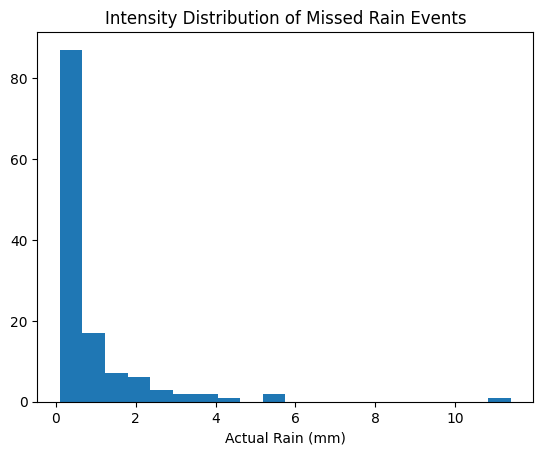

In [23]:
# Create a DataFrame of False Negatives (Missed Rain)
df_misses = X_test.copy()
df_misses['Actual'] = y_test
df_misses['Pred'] = preds_test_boosted2

# Filter: It Rained (>0.1) BUT Model stayed silent (<0.5)
mask_miss = (y_test >= 0.1) & (preds_test_boosted2 < 0.5)
df_misses = df_misses[mask_miss]

# Check the severity of the misses
max_miss = df_misses['Actual'].max()
avg_miss = df_misses['Actual'].mean()

print(f"Max Rain Missed: {max_miss:.2f} mm/hr")
print(f"Avg Rain Missed: {avg_miss:.2f} mm/hr")

# Histogram to see if misses are clustered at low intensity
import matplotlib.pyplot as plt
plt.hist(df_misses['Actual'], bins=20)
plt.title("Intensity Distribution of Missed Rain Events")
plt.xlabel("Actual Rain (mm)")
plt.show()

In [24]:
# 1. Identify the Index of the Max Miss
idx_max_miss = df_misses['Actual'].idxmax()

# 2. Extract the full feature row for that timestamp
failure_case = X_test.loc[idx_max_miss]
actual_val = y_test.loc[idx_max_miss]
pred_val = preds_test_boosted2[X_test.index.get_loc(idx_max_miss)] # mapped by integer location if numpy

print(f"Timestamp: {idx_max_miss}")
print(f"Actual: {actual_val} | Predicted: {pred_val}")
print("-" * 30)
print("Key Feature Values:")
# Print the RFSI Neighbor features
print(f"Neighbor 1 Rain: {failure_case['rain_tel_aviv']}") # Replace with your actual col name
# Print the Upstream features
print(f"Haifa Moisture Flux: {failure_case['moisture_flux_haifa_t-1h']}") 
print(f"TelAviv Moisture Flux: {failure_case['moisture_flux_tel_aviv_t-1h']}")

Timestamp: 2024-03-19 10:00:00
Actual: 11.399999999999999 | Predicted: 0.4408907890319824
------------------------------
Key Feature Values:
Neighbor 1 Rain: 0.0
Haifa Moisture Flux: 16.704606576377593
TelAviv Moisture Flux: 729.2548494503177
